In [1]:
# ===============================================================
# NVBP: No-waste tranche A + Residual Retail MNL on market (1-A)
#  - Winner must fulfill tranche A at bid price Pp (no waste)
#  - Residual market size is (1-A), with standard logit over {0,B,P,G}
#  - Winner’s retail price equals its bid Pp (fixed from the auction)
#  - Profits:
#      Winner: A*(Pp - MC_w) + (1-A)*sP_res*(Pp - MC_w)
#      Brand : (1-A)*sB_res*(Pb - MCb)
#      Loser : (1-A)*sG_res*(Pg - MC_l)
#  - Indifference: choose P such that Win_i(P) - Lose_i(P) = 0
# ===============================================================

from dataclasses import dataclass
from typing import Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Primitives
# --------------------------
@dataclass
class Common:
    alpha: float   # logit price sensitivity
    vb: float      # brand mean utility
    MCb: float     # brand marginal cost
    A: float       # tranche size (must be fulfilled; no waste)
    v0: float      # outside-option utility
    tau: float = 0.5  # tie-break prob if bids equal

@dataclass
class Gen:
    name: str
    vg: float      # (also winner) mean utility
    MCg: float     # marginal cost

# --------------------------
# Logit shares over {0, B, P, G} for residual market ONLY
# (these shares sum to 1 over residual market)
# --------------------------
def shares_residual_0BPG(pb: float, pp: float, pg: float,
                         Vb: float, Vp: float, Vg: float, V0: float,
                         alpha: float) -> Dict[str, float]:
    uB = Vb - alpha*pb
    uP = Vp - alpha*pp
    uG = Vg - alpha*pg
    u0 = V0
    eB, eP, eG, e0 = np.exp(uB), np.exp(uP), np.exp(uG), np.exp(u0)
    Z = e0 + eB + eP + eG
    return {"s0": e0/Z, "sB": eB/Z, "sP": eP/Z, "sG": eG/Z}

# --------------------------
# Helpers to format shares
# --------------------------
def fmt_residual_shares(s: Dict[str, float]) -> str:
    return (f"s0_res={s['s0']:.4f}, sP_res={s['sP']:.4f}, "
            f"sG_res={s['sG']:.4f}, sB_res={s['sB']:.4f}")

def total_shares_from_residual(s_res: Dict[str, float], A: float) -> Dict[str, float]:
    one_minus_A = max(0.0, 1.0 - A)
    return {
        "s0_tot": one_minus_A * s_res["s0"],
        "sB_tot": one_minus_A * s_res["sB"],
        "sP_tot": A + one_minus_A * s_res["sP"],  # tranche + residual demand
        "sG_tot": one_minus_A * s_res["sG"],
    }

# --------------------------
# Stage 2 (residual market): given Pp, Brand/Loser pick Pb,Pg
# --------------------------
def stage2_eval(pb: float, pg: float, Pp: float, *,
                Vb: float, Vp: float, Vg: float, V0: float,
                MCb: float, MCg_w: float, MCg_l: float,
                alpha: float, A: float) -> Dict:
    # Residual market shares on size (1-A)
    s_res = shares_residual_0BPG(pb, Pp, pg, Vb, Vp, Vg, V0, alpha)

    # Margins (clip negatives for stable plots if someone pushes below MC)
    margin_B = max(pb  - MCb,    0.0)
    margin_P = max(Pp  - MCg_w,  0.0)
    margin_G = max(pg  - MCg_l,  0.0)

    one_minus_A = max(0.0, 1.0 - A)

    # Profits on residual market
    prof_B_residual = one_minus_A * s_res["sB"] * margin_B
    prof_G_residual = one_minus_A * s_res["sG"] * margin_G
    prof_P_retail   = one_minus_A * s_res["sP"] * margin_P

    # Tranche must be fulfilled (no waste): A * margin_P
    prof_P_tranche  = A * margin_P

    winner_total    = prof_P_tranche + prof_P_retail

    # Also return total shares for reporting
    s_tot = total_shares_from_residual(s_res, A)

    return dict(
        shares_residual=s_res,                   # residual shares sum to 1
        shares_total=s_tot,                      # total-market shares sum to 1
        profit_brand_residual=prof_B_residual,
        profit_loser_residual=prof_G_residual,
        profit_winner_retail=prof_P_retail,      # residual part only
        profit_winner_tranche=prof_P_tranche,    # A * margin_P
        winner_total=winner_total
    )

def best_response_brand(pg_fixed: float, Pp: float, *,
                        Vb: float, Vp: float, Vg: float, V0: float,
                        MCb: float, MCg_w: float, MCg_l: float,
                        alpha: float, A: float, pb_bounds=(0.0, 400.0)) -> Tuple[float, Dict]:
    lo, hi = pb_bounds
    best_v, best_pb, best_eval = -1e300, None, None
    for N in (301, 161, 81, 41, 21):
        grid = np.linspace(lo, hi, N)
        vals = []
        for pb in grid:
            st = stage2_eval(pb, pg_fixed, Pp, Vb=Vb, Vp=Vp, Vg=Vg, V0=V0,
                             MCb=MCb, MCg_w=MCg_w, MCg_l=MCg_l, alpha=alpha, A=A)
            v = st["profit_brand_residual"]
            vals.append(v)
            if v > best_v:
                best_v, best_pb, best_eval = v, pb, st
        idx = int(np.argmax(vals))
        lo = max(pb_bounds[0], grid[max(0, idx-4)])
        hi = min(pb_bounds[1], grid[min(N-1, idx+4)])
    return float(best_pb), dict(best_profit=best_v, eval=best_eval)

def best_response_loser(pb_fixed: float, Pp: float, *,
                        Vb: float, Vp: float, Vg: float, V0: float,
                        MCb: float, MCg_w: float, MCg_l: float,
                        alpha: float, A: float, pg_bounds=(0.0, 400.0)) -> Tuple[float, Dict]:
    lo, hi = pg_bounds
    best_v, best_pg, best_eval = -1e300, None, None
    for N in (301, 161, 81, 41, 21):
        grid = np.linspace(lo, hi, N)
        vals = []
        for pg in grid:
            st = stage2_eval(pb_fixed, pg, Pp, Vb=Vb, Vp=Vp, Vg=Vg, V0=V0,
                             MCb=MCb, MCg_w=MCg_w, MCg_l=MCg_l, alpha=alpha, A=A)
            v = st["profit_loser_residual"]
            vals.append(v)
            if v > best_v:
                best_v, best_pg, best_eval = v, pg, st
        idx = int(np.argmax(vals))
        lo = max(pg_bounds[0], grid[max(0, idx-4)])
        hi = min(pg_bounds[1], grid[min(N-1, idx+4)])
    return float(best_pg), dict(best_profit=best_v, eval=best_eval)

def solve_stage2_prices(Pp: float, *,
                        Vb: float, Vp: float, Vg: float, V0: float,
                        MCb: float, MCg_w: float, MCg_l: float,
                        alpha: float, A: float,
                        pb_bounds=(0.0,400.0), pg_bounds=(0.0,400.0),
                        max_iter=60, tol=1e-6, damping=0.6) -> Dict:
    # Reasonable warm starts: p ≈ MC + 1/alpha
    inv_a = 1.0/max(alpha,1e-9)
    pb = max(pb_bounds[0], MCb     + inv_a)
    pg = max(pg_bounds[0], MCg_l   + inv_a)

    seq=[]
    for it in range(1, max_iter+1):
        pb_br, info_b = best_response_brand(pg, Pp, Vb=Vb, Vp=Vp, Vg=Vg, V0=V0,
                                            MCb=MCb, MCg_w=MCg_w, MCg_l=MCg_l,
                                            alpha=alpha, A=A, pb_bounds=pb_bounds)
        pb = (1-damping)*pb + damping*pb_br

        pg_br, info_g = best_response_loser(pb, Pp, Vb=Vb, Vp=Vp, Vg=Vg, V0=V0,
                                            MCb=MCb, MCg_w=MCg_w, MCg_l=MCg_l,
                                            alpha=alpha, A=A, pg_bounds=pg_bounds)
        pg = (1-damping)*pg + damping*pg_br

        seq.append((pb,pg,info_b["best_profit"],info_g["best_profit"]))
        if max(abs(pb-pb_br), abs(pg-pg_br)) < tol:
            break

    st = stage2_eval(pb, pg, Pp, Vb=Vb, Vp=Vp, Vg=Vg, V0=V0,
                     MCb=MCb, MCg_w=MCg_w, MCg_l=MCg_l, alpha=alpha, A=A)
    return dict(pb=pb, pg=pg, **st, converged=(it<max_iter), iterations=it, sequence=seq)

def stage2_given_winner(Pp: float, *, common: Common, winner: Gen, loser: Gen,
                        pb_bounds=(0.0,400.0), pg_bounds=(0.0,400.0)) -> Dict:
    sol = solve_stage2_prices(Pp,
                              Vb=common.vb, Vp=winner.vg, Vg=loser.vg, V0=common.v0,
                              MCb=common.MCb, MCg_w=winner.MCg, MCg_l=loser.MCg,
                              alpha=common.alpha, A=common.A,
                              pb_bounds=pb_bounds, pg_bounds=pg_bounds)
    return dict(Pb=sol["pb"], Pg=sol["pg"],
                shares_residual=sol["shares_residual"],
                shares_total=sol["shares_total"],
                profit_brand_residual=sol["profit_brand_residual"],
                profit_loser_residual=sol["profit_loser_residual"],
                profit_winner_retail=sol["profit_winner_retail"],
                profit_winner_tranche=sol["profit_winner_tranche"],
                winner_total=sol["winner_total"],
                solver_info=sol)

# --------------------------
# Indifference search (Δ continuous)
# --------------------------
def delta(i: Gen, j: Gen, common: Common, P: float,
          pb_bounds=(0.0,400.0), pg_bounds=(0.0,400.0)) -> float:
    """Δ(P) = Win_i(P) - Lose_i(P), with stage-2 solved at P."""
    # i loses at P (j wins)
    st_lose = stage2_given_winner(P, common=common, winner=j, loser=i,
                                  pb_bounds=pb_bounds, pg_bounds=pg_bounds)
    lose_i = st_lose["profit_loser_residual"]  # only residual piece for loser

    # i wins at P
    st_win = stage2_given_winner(P, common=common, winner=i, loser=j,
                                 pb_bounds=pb_bounds, pg_bounds=pg_bounds)
    win_i = st_win["winner_total"]  # tranche + residual retail

    return win_i - lose_i

def dagger_monotone(i: Gen, j: Gen, common: Common, *,
                    lower=None, upper=100.0, init=30.0, step=5.0,
                    pb_bounds=(0.0,400.0), pg_bounds=(0.0,400.0),
                    tol=1e-6, max_bisect=80):
    """Monotone scan from init: if Δ(init)>0 go down, else go up; bisection on bracket."""
    if lower is None:
        lower = i.MCg  # no-below-MC region for bids

    P0 = max(lower + 1e-9, init)
    d0 = delta(i, j, common, P0, pb_bounds, pg_bounds)
    direction = -1 if d0 > 0 else (+1 if d0 < 0 else 0)
    if direction == 0:
        return ("root", P0)

    def nxt(P): return max(lower+1e-9, P - step) if direction<0 else min(upper, P + step)

    P_prev, d_prev = P0, d0
    while True:
        P_cur = nxt(P_prev)
        if (direction<0 and P_cur <= lower+1e-9) or (direction>0 and P_cur >= upper-1e-9):
            return ("lower" if direction<0 else "upper", (lower if direction<0 else upper))
        d_cur = delta(i, j, common, P_cur, pb_bounds, pg_bounds)
        if d_prev * d_cur <= 0:  # bracket found
            a, fa = P_prev, d_prev
            b, fb = P_cur, d_cur
            if a>b: a,b,fa,fb = b,a,fb,fa
            for _ in range(max_bisect):
                m = 0.5*(a+b)
                fm = delta(i, j, common, m, pb_bounds, pg_bounds)
                if abs(fm) <= tol or (b-a) < tol:
                    return ("root", m)
                if fa*fm <= 0: b, fb = m, fm
                else:          a, fa = m, fm
            return ("root", 0.5*(a+b))
        P_prev, d_prev = P_cur, d_cur

# --------------------------
# Equilibrium (choose lower bidder; with symmetry it's the common root)
# --------------------------
def equilibrium_by_indifference(common: Common, g1: Gen, g2: Gen, *,
                                pb_bounds=(0.0,400.0), pg_bounds=(0.0,400.0),
                                upper=100.0, init=30.0, step=5.0, tol=1e-6) -> Dict:
    tag1, P1 = dagger_monotone(g1, g2, common, lower=g1.MCg, upper=upper, init=init, step=step,
                               pb_bounds=pb_bounds, pg_bounds=pg_bounds, tol=tol)
    tag2, P2 = dagger_monotone(g2, g1, common, lower=g2.MCg, upper=upper, init=init, step=step,
                               pb_bounds=pb_bounds, pg_bounds=pg_bounds, tol=tol)

    reason = f"g1:{tag1}@{P1:.6f}, g2:{tag2}@{P2:.6f}"

    # decide winner and Pp
    if tag1 == tag2 == "root":
        if abs(P1-P2) <= tol:
            Pp = 0.5*(P1+P2); winner, loser = g1, g2; mode="indifference"
        else:
            Pp = max(P1, P2); winner = (g1 if P1 < P2 else g2); loser = (g2 if winner is g1 else g1); mode="indifference (asym.)"
    elif tag1 == tag2 == "lower":
        Pp = max(g1.MCg, g2.MCg); winner, loser = g1, g2; mode="guard: lower (MC)"
    elif tag1 == tag2 == "upper":
        Pp = upper; winner, loser = g1, g2; mode="guard: upper"
    else:
        # mixed tags: pick smallest feasible price; lower bidder wins
        candidates=[]
        for tag,P,who in [(tag1,P1,g1),(tag2,P2,g2)]:
            if tag=="root": candidates.append((P,who))
            if tag=="lower": candidates.append((who.MCg,who))
            if tag=="upper": candidates.append((upper,who))
        Pp, winner = min(candidates, key=lambda x:x[0]); loser = g2 if winner is g1 else g1; mode="mixed"

    st = stage2_given_winner(Pp, common=common, winner=winner, loser=loser,
                             pb_bounds=pb_bounds, pg_bounds=pg_bounds)

    # unpack shares for convenience
    s_res = st["shares_residual"]
    s_tot = st["shares_total"]

    return dict(mode=mode, reason=reason, winner=winner.name, loser=loser.name,
                Pp_star=Pp, Pb_star=st["Pb"], Pg_star=st["Pg"],
                profit_brand_residual=st["profit_brand_residual"],
                profit_loser_residual=st["profit_loser_residual"],
                profit_winner_retail=st["profit_winner_retail"],
                profit_winner_tranche=st["profit_winner_tranche"],
                winner_total=st["winner_total"],
                shares_residual=s_res, shares_total=s_tot,
                s0_res=s_res["s0"], sP_res=s_res["sP"], sG_res=s_res["sG"], sB_res=s_res["sB"],
                s0_tot=s_tot["s0_tot"], sP_tot=s_tot["sP_tot"], sG_tot=s_tot["sG_tot"], sB_tot=s_tot["sB_tot"])

# --------------------------
# Plot: expected profit vs own bid (no-waste tranche)
# --------------------------
def plot_expected_profit_vs_own_bid(common: Common, g1: Gen, g2: Gen, *,
                                    me_name: str, Pj_fixed: float,
                                    Pi_min: float, Pi_max: float, Pi_points: int,
                                    pb_bounds=(0.0,400.0), pg_bounds=(0.0,400.0)):
    me    = g1 if me_name=="g1" else g2
    rival = g2 if me_name=="g1" else g1

    base = np.linspace(Pi_min, Pi_max, Pi_points)
    eps = 1e-8
    Pi_grid = np.unique(np.r_[base, max(Pi_min, Pj_fixed-eps), Pj_fixed])

    E = np.zeros_like(Pi_grid)
    win_line = np.zeros_like(Pi_grid)

    # me loses at Pj (rival wins)
    st_lose = stage2_given_winner(Pj_fixed, common=common, winner=rival, loser=me,
                                  pb_bounds=pb_bounds, pg_bounds=pg_bounds)
    lose_flat = st_lose["profit_loser_residual"]

    for k,Pi in enumerate(Pi_grid):
        if Pi < Pj_fixed:
            st_win = stage2_given_winner(Pi, common=common, winner=me, loser=rival,
                                         pb_bounds=pb_bounds, pg_bounds=pg_bounds)
            win_payoff = st_win["winner_total"]     # A*(P-MC) + (1-A)*sP_res*(P-MC)
            E[k] = win_payoff
            win_line[k] = win_payoff
        else:
            E[k] = lose_flat

    plt.figure(figsize=(7.4,4.3))
    plt.plot(Pi_grid, E, label=f"Expected profit (given Pj={Pj_fixed:.4f})")
    plt.plot(Pi_grid, np.where(Pi_grid < Pj_fixed, win_line, np.nan), linestyle="--",
             label="Win payoff (tranche + residual)")
    plt.axvline(Pj_fixed, linestyle=":", label="Pj (opponent bid)")
    plt.scatter([Pj_fixed], [lose_flat], zorder=5, marker="x", label=f"Lose at Pj = {lose_flat:.4f}")
    plt.xlabel("Own bid Pi"); plt.ylabel("Expected profit")
    plt.title(f"{me.name}: Expected profit vs own bid (no-waste tranche)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

============ NVBP equilibrium (NO-WASTE tranche, residual MNL on 1-A) ============
                        mode: indifference
                      reason: g1:root@24.795384, g2:root@24.795384
                      winner: g1
                       loser: g2
                     Pp_star: 24.795384407043457
                     Pb_star: 94.76699275997333
                     Pg_star: 70.73473169513241
       profit_winner_tranche: 2.832922983169556
        profit_winner_retail: 1.4517040454903705
                winner_total: 4.284627028659926
       profit_brand_residual: 15.577422766574355
       profit_loser_residual: 4.28462767053863
   shares_residual (0,P,G,B): s0=0.0424, sP=0.4193, sG=0.1491, sB=0.3892
      shares_total (0,P,G,B): s0=0.0233, sP=0.6806, sG=0.0820, sB=0.2141


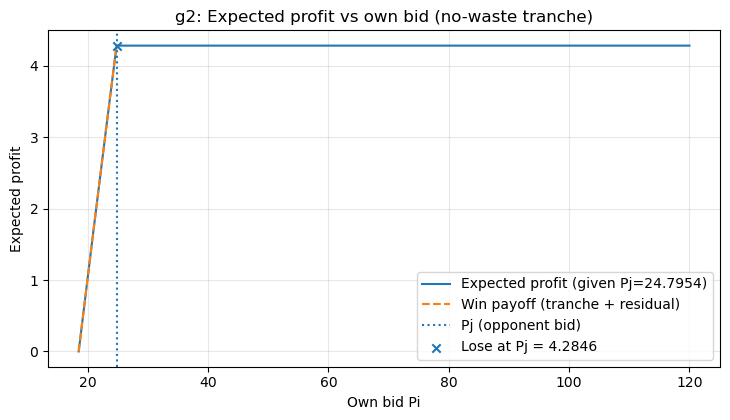

In [3]:
# ===============================================================
# Runner (example)
# ===============================================================
if __name__ == "__main__":
    # primitives (tweak)
    common = Common(alpha=0.0225, vb=3.95, MCb=22.0, A=0.45, v0=-0.4, tau=0.5)
    g1 = Gen(name="g1", vg=2.45, MCg=18.5)
    g2 = Gen(name="g2", vg=2.45, MCg=18.5)

    PB = (common.MCb, 200.0)
    PG = (min(g1.MCg,g2.MCg), 200.0)

    eq = equilibrium_by_indifference(common, g1, g2,
                                     pb_bounds=PB, pg_bounds=PG,
                                     upper=100.0, init=30.0, step=5.0, tol=1e-6)

    print("============ NVBP equilibrium (NO-WASTE tranche, residual MNL on 1-A) ============")
    for k in ["mode","reason","winner","loser","Pp_star","Pb_star","Pg_star",
              "profit_winner_tranche","profit_winner_retail","winner_total",
              "profit_brand_residual","profit_loser_residual"]:
        v = eq[k] if k in eq else "—"
        print(f"{k:>28}: {v}")

    # Residual shares (sum to 1)
    print(f"{'shares_residual (0,P,G,B)':>28}: "
          f"s0={eq['s0_res']:.4f}, sP={eq['sP_res']:.4f}, sG={eq['sG_res']:.4f}, sB={eq['sB_res']:.4f}")
    # Total shares (sum to 1): P already includes the tranche
    print(f"{'shares_total (0,P,G,B)':>28}: "
          f"s0={eq['s0_tot']:.4f}, sP={eq['sP_tot']:.4f}, sG={eq['sG_tot']:.4f}, sB={eq['sB_tot']:.4f}")

    # Plot expected profit vs own bid for the loser at the equilibrium Pp*
    me_name = "g2" if eq["winner"]=="g1" else "g1"
    plot_expected_profit_vs_own_bid(common, g1, g2,
                                    me_name=me_name,
                                    Pj_fixed=eq["Pp_star"],
                                    Pi_min=min(g1.MCg,g2.MCg), Pi_max=120.0, Pi_points=601,
                                    pb_bounds=PB, pg_bounds=PG)

In [4]:
# ===============================================================
# Retail-only MNL equilibrium with Brand (B) and one Generic (G)
#   - Outside option present
#   - Prices (pB, pG) chosen simultaneously (Nash)
#   - Uses the same Common/Gen primitives as your other code
# ===============================================================

from dataclasses import dataclass
from typing import Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Primitives (reuse your types)
# --------------------------
@dataclass
class Common:
    alpha: float   # logit price sensitivity
    vb: float      # brand mean utility
    MCb: float     # brand marginal cost
    v0: float      # outside option utility

@dataclass
class Gen:
    name: str
    vg: float      # generic mean utility
    MCg: float     # generic marginal cost

# --------------------------
# Logit shares over {0, B, G}
# --------------------------
def shares_0BG(pb: float, pg: float, *, Vb: float, Vg: float, V0: float, alpha: float) -> Dict[str, float]:
    uB = Vb - alpha*pb
    uG = Vg - alpha*pg
    u0 = V0
    eB, eG, e0 = np.exp(uB), np.exp(uG), np.exp(u0)
    Z = e0 + eB + eG
    return {"s0": e0/Z, "sB": eB/Z, "sG": eG/Z}

# --------------------------
# Objective evaluation at (pb, pg)
# --------------------------
def eval_profits(pb: float, pg: float, *,
                 Vb: float, Vg: float, V0: float,
                 MCb: float, MCg: float, alpha: float) -> Dict:
    s = shares_0BG(pb, pg, Vb=Vb, Vg=Vg, V0=V0, alpha=alpha)
    margin_B = max(pb - MCb, 0.0)  # clamp for safe plotting (can remove if not needed)
    margin_G = max(pg - MCg, 0.0)
    piB = s["sB"] * margin_B
    piG = s["sG"] * margin_G
    return dict(shares=s, piB=piB, piG=piG)

# --------------------------
# Best responses (grid search with zoom)
# --------------------------
def best_response_brand(pg_fixed: float, *,
                        Vb: float, Vg: float, V0: float,
                        MCb: float, MCg: float, alpha: float,
                        pb_bounds=(0.0, 400.0)) -> Tuple[float, Dict]:
    lo, hi = pb_bounds
    best_v, best_pb, best_eval = -1e300, None, None
    for N in (301, 161, 81, 41, 21):
        grid = np.linspace(lo, hi, N)
        vals = []
        for pb in grid:
            st = eval_profits(pb, pg_fixed, Vb=Vb, Vg=Vg, V0=V0, MCb=MCb, MCg=MCg, alpha=alpha)
            v = st["piB"]
            vals.append(v)
            if v > best_v:
                best_v, best_pb, best_eval = v, pb, st
        idx = int(np.argmax(vals))
        lo = max(pb_bounds[0], grid[max(0, idx-4)])
        hi = min(pb_bounds[1], grid[min(N-1, idx+4)])
    return float(best_pb), dict(best_profit=best_v, eval=best_eval)

def best_response_generic(pb_fixed: float, *,
                          Vb: float, Vg: float, V0: float,
                          MCb: float, MCg: float, alpha: float,
                          pg_bounds=(0.0, 400.0)) -> Tuple[float, Dict]:
    lo, hi = pg_bounds
    best_v, best_pg, best_eval = -1e300, None, None
    for N in (301, 161, 81, 41, 21):
        grid = np.linspace(lo, hi, N)
        vals = []
        for pg in grid:
            st = eval_profits(pb_fixed, pg, Vb=Vb, Vg=Vg, V0=V0, MCb=MCb, MCg=MCg, alpha=alpha)
            v = st["piG"]
            vals.append(v)
            if v > best_v:
                best_v, best_pg, best_eval = v, pg, st
        idx = int(np.argmax(vals))
        lo = max(pg_bounds[0], grid[max(0, idx-4)])
        hi = min(pg_bounds[1], grid[min(N-1, idx+4)])
    return float(best_pg), dict(best_profit=best_v, eval=best_eval)

# --------------------------
# Solve Nash prices by BR iteration (damped)
# --------------------------
def solve_retail_only_equilibrium(*,
                                  common: Common, generic: Gen,
                                  pb_bounds=(0.0, 400.0), pg_bounds=(0.0, 400.0),
                                  max_iter=60, tol=1e-6, damping=0.6) -> Dict:
    # warm starts near MC + 1/alpha
    inv_a = 1.0 / max(common.alpha, 1e-9)
    pb = max(pb_bounds[0], common.MCb + inv_a)
    pg = max(pg_bounds[0], generic.MCg + inv_a)

    seq = []
    for it in range(1, max_iter+1):
        # Brand BR
        pb_br, info_b = best_response_brand(pg,
                    Vb=common.vb, Vg=generic.vg, V0=common.v0,
                    MCb=common.MCb, MCg=generic.MCg, alpha=common.alpha,
                    pb_bounds=pb_bounds)
        pb = (1 - damping)*pb + damping*pb_br

        # Generic BR
        pg_br, info_g = best_response_generic(pb,
                    Vb=common.vb, Vg=generic.vg, V0=common.v0,
                    MCb=common.MCb, MCg=generic.MCg, alpha=common.alpha,
                    pg_bounds=pg_bounds)
        pg = (1 - damping)*pg + damping*pg_br

        seq.append((pb, pg, info_b["best_profit"], info_g["best_profit"]))
        if max(abs(pb - pb_br), abs(pg - pg_br)) < tol:
            break

    # Final evaluation
    st = eval_profits(pb, pg, Vb=common.vb, Vg=generic.vg, V0=common.v0,
                      MCb=common.MCb, MCg=generic.MCg, alpha=common.alpha)
    return dict(pb_star=pb, pg_star=pg,
                shares=st["shares"], piB=st["piB"], piG=st["piG"],
                converged=(it < max_iter), iterations=it, sequence=seq)

# --------------------------
# Optional: plot best-response profits vs own price
# --------------------------
def plot_profit_curves(common: Common, generic: Gen,
                       pb_bounds=(0.0, 200.0), pg_bounds=(0.0, 200.0),
                       other_fix=None):
    Vb, Vg, V0, a = common.vb, generic.vg, common.v0, common.alpha
    MCb, MCg = common.MCb, generic.MCg

    # Fix rival prices at their BR solution if given, else near MC+1/alpha
    if other_fix is None:
        inv_a = 1.0/max(a,1e-9)
        pb_fix = MCb + inv_a
        pg_fix = MCg + inv_a
    else:
        pb_fix, pg_fix = other_fix

    # Brand curve
    pb_grid = np.linspace(pb_bounds[0], pb_bounds[1], 401)
    piB = [eval_profits(pb, pg_fix, Vb=Vb, Vg=Vg, V0=V0, MCb=MCb, MCg=MCg, alpha=a)["piB"]
           for pb in pb_grid]
    # Generic curve
    pg_grid = np.linspace(pg_bounds[0], pg_bounds[1], 401)
    piG = [eval_profits(pb_fix, pg, Vb=Vb, Vg=Vg, V0=V0, MCb=MCb, MCg=MCg, alpha=a)["piG"]
           for pg in pg_grid]

    plt.figure(figsize=(7.6, 4.0))
    plt.plot(pb_grid, piB, label="Brand profit vs pB (pG fixed)")
    plt.plot(pg_grid, piG, label="Generic profit vs pG (pB fixed)")
    plt.xlabel("Price"); plt.ylabel("Profit")
    plt.title("Best-response profit curves (retail-only MNL, 0/B/G)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# ===============================================================
# Runner (example)
# ===============================================================
if __name__ == "__main__":
    # Example primitives (reuse your values)
    common = Common(alpha=0.0225, vb=3.95, MCb=22.0, v0=-0.3)
    g = Gen(name="g", vg=2.45, MCg=18.5)

    PB = (common.MCb, 200.0)
    PG = (g.MCg, 200.0)

    sol = solve_retail_only_equilibrium(common=common, generic=g,
                                        pb_bounds=PB, pg_bounds=PG,
                                        max_iter=80, tol=1e-7, damping=0.6)

    s = sol["shares"]
    print("============ Retail-only MNL equilibrium (0, B, G) ============")
    print(f"{'converged':>18}: {sol['converged']} in {sol['iterations']} iters")
    print(f"{'pB*':>18}: {sol['pb_star']:.6f}")
    print(f"{'pG*':>18}: {sol['pg_star']:.6f}")
    print(f"{'piB':>18}: {sol['piB']:.6f}")
    print(f"{'piG':>18}: {sol['piG']:.6f}")
    print(f"{'shares (0,B,G)':>18}: s0={s['s0']:.6f}, sB={s['sB']:.6f}, sG={s['sG']:.6f}")

    # Optional: visualize profit curves around warm starts
    # plot_profit_curves(common, g, pb_bounds=(common.MCb, 120.0), pg_bounds=(g.MCg, 120.0))


============ Retail-only MNL equilibrium (0, B, G) ============
         converged: True in 29 iters
               pB*: 123.299563
               pG*: 82.953070
               piB: 56.855187
               piG: 20.008532
    shares (0,B,G): s0=0.128306, sB=0.561258, sG=0.310436
